# Problema
El *Solar Dynamics Observatory* es un telescopio espacial que puede realizar mediciones continuas (casi en tiempo real) del Sol. Particularmente, posee el *HMI* (generador de imágenes heliosísmicas y magnéticas) que permite la recopilación de datos sobre el estado del campo magnético en regiones activas (AR) de la superficie solar. Las AR son de especial importancia pues generalmente las fulguraciones solares (y también las eyecciones de masa coronal) provienen de las mismas. En este ejemplo, voy a replicar un estudio real (*Florios, Kostas and Kontogiannis: 2018, Forecasting Solar Flares Using Magnetogram-based Predictors and Machine Learning*) en el que los autores prueban la posibilidad de usar algunos algoritmos de aprendizaje automático para predecir fulguraciones solares de tipo C y M.

#### Objetivo: **Usar datos obtenidos del HMI para predecir la ocurrencia de fulguraciones solares de tipo C.**

# Obtención de datos
Los autores proveen los datos ya reducidos que ellos mismos usaron para entrenar a sus algoritmos (lo cuál es genial porque permite la replicación y verificación de sus resultados!). En el paper en sí, ellos explican que obtuvieron los datos de la base de datos publica del SDO. Yo solo utilizo los datos que ellos proveen.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.model_selection import GridSearchCV

In [ ]:
# https://arxiv.org/pdf/1801.05744.pdf

# set the paths for both features and labels for class C solar flares
# CAMBIAR CON EL FILE EN TU COMPUTADORA
pathFeaturesC = '/content/drive/MyDrive/datasets/SolarFlareForecasting/Xall.txt'
pathLabelsC = '/content/drive/MyDrive/datasets/SolarFlareForecasting/Yall.txt' 

# load the dataset in numpy arrays
classCfeatures = np.loadtxt(pathFeaturesC, delimiter=' ')
classClabels = np.loadtxt(pathLabelsC, delimiter=' ')

# concatenate both and display shape
classCDataset = np.hstack((classCfeatures, classClabels.reshape((classClabels.size,1))))

# put it into a pandas DataFrame and show first few cases
feature_names = ["alpha_exp_fft_blos","alpha_exp_fft_br",
"decay_index_blos","decay_index_br",
"ising_energy_blos","ising_energy_br",
"ising_energy_part_blos","ising_energy_part_br",
"mpil_blos","mpil_br",
"nn_currents",
"r_value_blos_logr","r_value_br_logr",
"wlsg_blos","wlsg_br"]


# Exploración
Los autores usan 15 variables especializadas que miden distintas propiedades relevantes de los campos magnéticos en las regiones activas que ellos seleccionaron, y siendo honesto, son un poco avanzadas y no entiendo perfectamente que es lo que significa cada una. Sin embargo, ellos describen como seleccionaron estas variables (basandose en argumentos tanto teóricos y empíricos). Aquí esta la tabla con algunos de los datos que ellos usaron.

In [ ]:
Class_C_pd = pd.DataFrame(classCDataset, columns=feature_names + ["y_GT_C1"])
Class_C_pd.head(10)

,alpha_exp_fft_blos,alpha_exp_fft_br,decay_index_blos,decay_index_br,ising_energy_blos,ising_energy_br,ising_energy_part_blos,ising_energy_part_br,mpil_blos,mpil_br,nn_currents,r_value_blos_logr,r_value_br_logr,wlsg_blos,wlsg_br,y_GT_C1
0,-2.158341,-1.656584,4.033333,7.966667,44160.773438,146.655746,64.350677,91.093933,1434.229980,66.367134,0.0,3.796749,4.276880,5491.607910,56192.617188,1.0
1,-1.522695,-1.589781,0.146341,7.000000,673.985840,121663.203125,3.685454,103.715042,1346.906250,62.989857,0.0,0.000000,4.208902,0.000000,55712.757812,0.0
2,-2.679130,-1.598090,5.176470,13.700000,29505.529297,148071.093750,51.445038,131.707550,1601.227417,72.689018,0.0,4.067752,4.337876,7511.451660,53778.453125,0.0
3,-2.014824,-1.484963,0.000000,4.088235,8234.035156,146240.500000,0.000000,133.027115,1576.589111,69.898277,0.0,3.454784,4.402648,2074.802246,55537.144531,0.0
4,-1.888601,-1.503151,0.000000,5.866666,533.671997,78316.554688,0.000000,77.091805,1219.218628,49.663952,0.0,2.018816,4.261858,200.188141,34613.937500,0.0
5,-1.124739,-1.384792,0.000000,6.233333,0.000000,75307.781250,0.000000,101.991638,1194.827026,53.243416,0.0,0.000000,4.179734,0.000000,38563.351562,0.0
6,-1.121778,-1.353720,0.000000,8.233334,6.629903,69013.164062,0.000000,134.174866,1309.328247,56.587051,0.0,0.000000,4.062629,0.000000,33456.878906,0.0
7,-1.351491,-1.344998,0.000000,0.733333,288.599487,14979.592773,0.000000,112.770493,1138.340210,49.937943,0.0,0.000000,4.173825,0.000000,32123.687500,0.0
8,-1.144062,-1.101569,1.023810,0.325581,12978.400391,17217.378906,11.975385,7.529749,7.529749,0.677013,0.0,3.180826,2.744522,3201.648926,2193.253174,0.0
9,-1.177468,-1.139751,0.880952,0.292683,13931.237305,19209.416016,10.371287,6.120760,6.120760,0.345818,0.0,2.709661,2.672005,4266.463867,2157.544434,0.0


# Preparación de datos
Para nosotros, no hay mucho que hacer acá (porque los autores ya reducieron los datos), aunque si explican que antes de entrenar los algoritmos debemos de *estandarizar* cada una de las variables (realizar una escala que deje a cada variable con un promedio igual a 0 y una desviación estándar igual a 1). También creamos el set de entrenamiento y el set de evaluación.

In [ ]:
# first we separate the entire data set into training and test, using stratified splitter
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for train_index, test_index in split.split(Class_C_pd, Class_C_pd["y_GT_C1"]):
    strat_train_set = Class_C_pd.loc[train_index]
    strat_test_set = Class_C_pd.loc[test_index]

# now separate the training data set into feaures and labels
X_train = strat_train_set[feature_names].values
Y_train = strat_train_set['y_GT_C1'].values

# now separate the training data set into feaures and labels
X_test = strat_test_set[feature_names].values
Y_test = strat_test_set['y_GT_C1'].values

y_train = Y_train == 1.0 # 1 if its star, 0 if its galaxy
y_test = Y_test == 1.0 # 1 if its star, 0 if its galaxy


In [ ]:
# Use standard scaler for training set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


# Entrenamiento de Algoritmo
Aquí entreno solamente un algoritmo: Random Forest (bosque aleatorio), el cual fue el que obtuvo mejores resultados en el estudio.

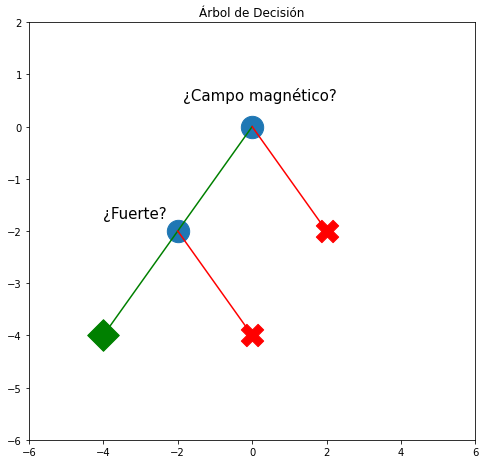

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Árbol de Decisión')

ax.text(-1.87, 0.5, '¿Campo magnético?', fontsize=15)
ax.text(-4, -1.75, '¿Fuerte?', fontsize=15)

ssss = 500

plt.plot([-4,-2,0], [-4,-2,0], color="green")
plt.plot([0,2], [0,-2], color="red")
plt.plot([0,-2], [-4,-2], color="red")
plt.scatter([0,-2], [0, -2], s=ssss)#, s=75)
plt.scatter([2,0],[-2,-4], marker='X', s=ssss, color='red')
plt.scatter([-4],[-4], marker='D', s=ssss, color='green')

ax.axis([-6, 6, -6, 2])

plt.show()

In [ ]:
# now we can train a random forest classifier
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()

forest_clf = RandomForestClassifier(random_state=1000, max_features="sqrt", n_estimators=500)
forest_clf.fit(X_train_scaled, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 15.955843210220337 seconds ---


# Evaluación
De nuevo, voy a utilizar el porcentaje de aciertos, pero tambien uso otros dos métodos de evaluación más especializados que los autores utilizan:

- **True Skill Score (TSS)**: Puede variar de -1 a 1, -1 siendo terriblemente malo, 0 siendo igual que un clasificador aleatorio, 1 siendo un clasificador perfecto.

- **Heidke Skill Score (HSS)**: Puede variar de menos infito a 1 y es similar a el TSS.

In [ ]:
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score

y_test_predicted = forest_clf.predict(X_test_scaled)

def tss_scorer_function(y_true, y_pred):
    # make confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # get individual values
    tp = cm[1, 1] # true positive
    tn = cm[0, 0] # true negative
    fp = cm[0, 1] # false positive
    fn = cm[1, 0] # false negative    

    # get true skill score
    tss = (tp/(tp+fn)) - (fp/(fp+tn))

    return tss

def hss_scorer_function(y_true, y_pred):
    # make confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # get individual values
    tp = cm[1, 1] # true positive
    tn = cm[0, 0] # true negative
    fp = cm[0, 1] # false positive
    fn = cm[1, 0] # false negative    

    # get Heidke skill score
    numerator = 2*((tp*tn) - (fp*fn))
    denominator = ((tp+fn)*(fn+tn)) + ((tp+fp)*(fp+tn))
    hss = numerator/denominator

    return hss

print(f'El porcentaje de aciertos es de: {accuracy_score(y_test, y_test_predicted)}')
print(f'El TSS es de: {tss_scorer_function(y_test, y_test_predicted)}')
print(f'El HSS es de: {hss_scorer_function(y_test, y_test_predicted)}')


El porcentaje de aciertos es de: 0.8308982450073485
El TSS es de: 0.57491990881479
El HSS es de: 0.5671211504674621


# Mejorar y Repetir
El bosque aleatorio usa una probabilidad mínima del 50% para hacer una predicción afirmativa. Cambiar este límite puede mejorar aún más los resultados. Los autores deciden cambiar este límite desde 0% hasta 100% usando incrementos del 5%. Acá tuve que modificar un poco la implementación del RF para manipular este límite, y prové exactamente lo mismo.

In [ ]:
# make a child of RandomForestClassifier overriding the predict method to use a threshold
class RandomForestClassifierWithThreshold(RandomForestClassifier):

    # change __init__ to include new attribute called threshold
    def __init__(self, random_state=42, max_features='sqrt', n_estimators=100, threshold=.5):
        RandomForestClassifier.__init__(self,random_state=random_state, 
                                        max_features=max_features, 
                                        n_estimators=n_estimators)
        self.threshold = threshold

    # override the parent predict method
    def predict(self, X):
        return self.predict_proba(X)[:,1] >= self.threshold


In [ ]:
# create RF with custom threshold
forest_tr_clf_grid = RandomForestClassifierWithThreshold()

# grid of parameters for the random forest
param_grid_forest_tr = [{'threshold': np.linspace(0.0,1, 21),
                         'n_estimators': [100],}]

# create dictionary of scorers
scoring = {'ACC': 'accuracy', 
           'TSS': make_scorer(tss_scorer_function), 
           'HSS': make_scorer(hss_scorer_function)}

# grid search cv with the accuracy scorer 
grid_search_rf_tr_complete = GridSearchCV(forest_tr_clf_grid, param_grid_forest_tr, 
                                          cv=3, verbose=1, scoring=scoring, refit=False)
grid_search_rf_tr_complete.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:  2.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifierWithThreshold(max_features='sqrt',
                                                           n_estimators=100,
                                                           random_state=42,
                                                           threshold=0.5),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_estimators': [100],
                          'threshold': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}],
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring={'ACC': 'accuracy',
                      'HSS': make_scorer(hss_scorer_function),
                      'TSS': make_scorer(tss_scorer_function)},
             verbose=1)

In [ ]:
thresholds_used = np.linspace(0.0,1, 21)
acc_results = grid_search_rf_tr_complete.cv_results_['mean_test_ACC']
tss_results = grid_search_rf_tr_complete.cv_results_['mean_test_TSS']
hss_results = grid_search_rf_tr_complete.cv_results_['mean_test_HSS']

Results_C_pd = pd.DataFrame(np.vstack((thresholds_used, acc_results, tss_results, hss_results)).T, 
                            columns=['Threshold', 'ACC', 'TSS', 'HSS'])
#Results_C_pd.to_excel('my_results_2.xlsx')
Results_C_pd.head(21)

,Threshold,ACC,TSS,HSS
0,0.00,0.260655,0.000000,0.000000
1,0.05,0.500564,0.312248,0.194335
2,0.10,0.631193,0.471751,0.330274
3,0.15,0.712459,0.551817,0.425233
4,0.20,0.749201,0.580469,0.471529
5,0.25,0.783695,0.596201,0.515127
6,0.30,0.815164,0.600969,0.556172
7,0.35,0.836345,0.601271,0.586134
8,0.40,0.845682,0.592211,0.596646
9,0.45,0.850178,0.564362,0.592171


# Conclusiones
Logramos crear un predictor de fulguraciones solares de tipo C siguiendo la metodología descrita en un artículo científico. Exploramos nuevas métricas de evaluación e incluso modificamos el algoritmo de Bosques Aleatorios para obtener mejores resultados.